# Disorder clusters

Goal: Do cell type enrichment analysis

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [181]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from enrichments import *
from disorders import *
from gradientVersion import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

In [3]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [4]:
version = dm_hcp_3d_ds5
scores = version.clean_scores()
weights = version.weights.iloc[:,:3]

In [5]:
# null_scores = version.make_null_scores(n=1000, save_name = 'hcp_3d_ds5_sim_1000')
null_scores = np.load('../outputs/permutations/hcp_3d_ds5_sim_1000.npy')

In [6]:
null_weights = shuffle_gene_weights(version.weights, n=1000, rank=False)

In [7]:
t1t2 = get_maps(rename=False)['T1T2']

## Disorders

In [183]:
disorders = ['ASD','MDD','SCZ']

In [184]:
gandal_genes = get_gandal_genes()
weights_labels = get_gene_weights_with_labels(weights, gandal_genes)

In [185]:
weights_labels

0         1         2 label    log2FC       FDR  \
A1BG     -0.015451 -0.004936  0.000697  none       NaN       NaN   
A1BG-AS1 -0.011982 -0.001214 -0.016186  none       NaN       NaN   
AAAS      0.011610  0.004923  0.002747  none       NaN       NaN   
AAED1    -0.013839 -0.000381  0.008322  none       NaN       NaN   
AAGAB    -0.005098  0.019884 -0.014750  none       NaN       NaN   
...            ...       ...       ...   ...       ...       ...   
ZSWIM9   -0.009991  0.000473  0.002506  none       NaN       NaN   
ZWINT    -0.012440 -0.008334  0.000573  none       NaN       NaN   
ZYX       0.017013  0.005948 -0.003733   SCZ -0.054705  0.019563   
ZZEF1     0.013004 -0.012945  0.009701  none       NaN       NaN   
ZZZ3     -0.010819 -0.004824  0.001799   SCZ  0.056258  0.045840   

                cluster  
A1BG               None  
A1BG-AS1           None  
AAAS               None  
AAED1              None  
AAGAB              None  
...                 ...  
ZSWIM9             None  
ZWINT              None  
ZYX       downregulated  
ZZEF1              None  
ZZZ3        upregulated  

[8321 rows x 7 columns]

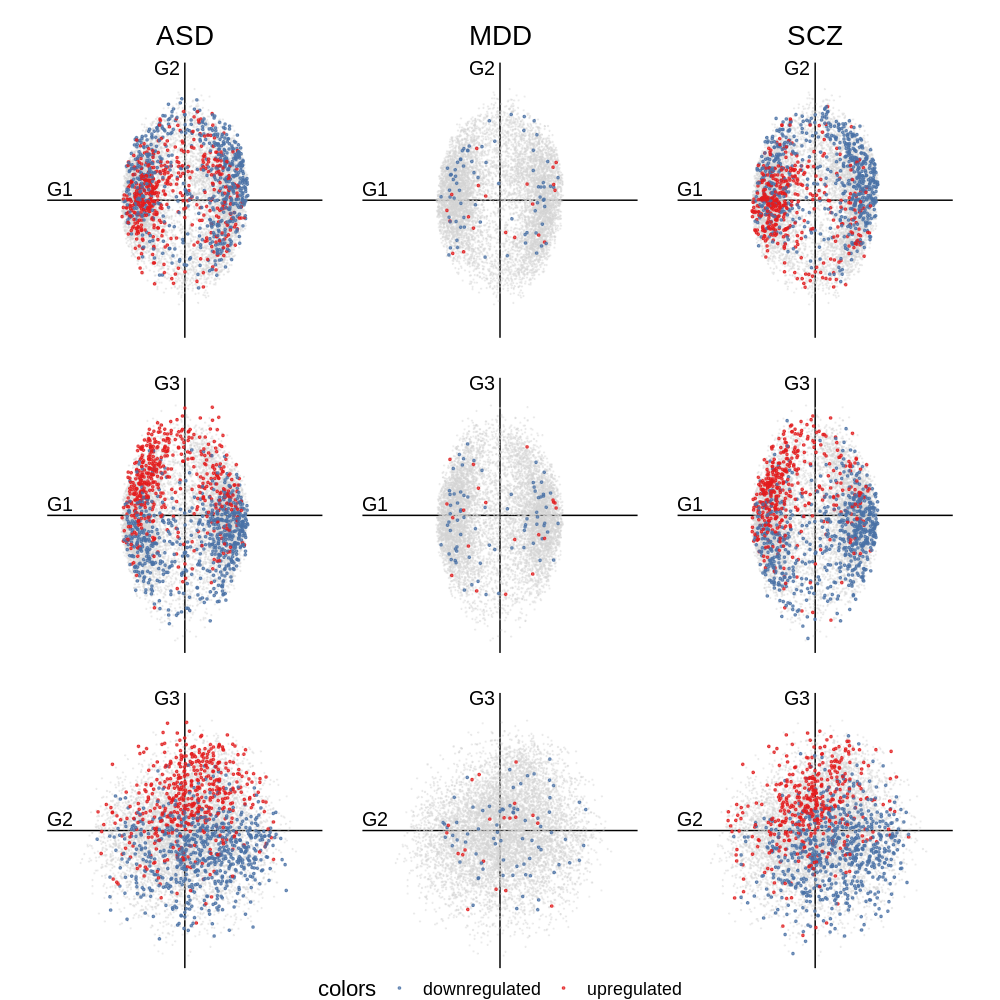

In [189]:
%%R -i weights_labels -w 10 -h 10 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_labels, colors=rev(brewer.set1(10)[1:2]), title='')
# plot_weight_scatters_with_labels(weights_labels %>% filter(cluster!='downregulated'), colors=brewer.set1(10)[1], title='Upregulated') |
# plot_weight_scatters_with_labels(weights_labels %>% filter(cluster!='upregulated'), colors=brewer.set1(10)[2], title='Downregulated')

In [98]:
weights_clusters = weights_labels

In [106]:
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    if disorder == 'none':
        continue    
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [107]:
(pd.concat(disorder_enrichments, axis=1)
 .loc[pd.IndexSlice[:,range(20)], pd.IndexSlice[['ASD','SCZ'],:]].sort_index(0)
 # .loc[['G1-/G3+','G1-/G3-']]
)


ASD  \
                                                               term   
downregulated 0                                  synaptic signaling   
              1                      proton transmembrane transport   
              2                                    cation transport   
              3                              nadh metabolic process   
              4                                    export from cell   
              5                      cation transmembrane transport   
              6                             transmembrane transport   
              7                                 aerobic respiration   
              8                                      signal release   
              9                         nitrogen compound transport   
              10                         neurotransmitter transport   
              11                           tricarboxylic acid cycle   
              12              regulation of neurotransmitter levels   
              13                         neurotransmitter secretion   
              14                                      ion transport   
              15                                cell cell signaling   
              16                        ion transmembrane transport   
              17                                    amine transport   
              18       regulation of clathrin dependent endocytosis   
              19                                          secretion   
upregulated   0                                    defense response   
              1   biological process involved in interspecies in...   
              2         regulation of cell population proliferation   
              3                    regulation of response to stress   
              4                                     immune response   
              5                                     cell activation   
              6                 regulation of immune system process   
              7                                  tube morphogenesis   
              8                                 biological adhesion   
              9                               inflammatory response   
              10                           regulation of cell death   
              11  regulation of multicellular organismal develop...   
              12                                   tube development   
              13                         blood vessel morphogenesis   
              14                       leukocyte cell cell adhesion   
              15                            vasculature development   
              16                      regulation of immune response   
              17  positive regulation of multicellular organisma...   
              18                     circulatory system development   
              19                        regulation of cell adhesion   

                                              \
                             p           fdr   
downregulated 0   3.546061e-08  8.576218e-05   
              1   4.319425e-08  8.576218e-05   
              2   1.381815e-06  1.803482e-03   
              3   1.816653e-06  1.803482e-03   
              4   6.902339e-06  5.481837e-03   
              5   1.114523e-05  6.800670e-03   
              6   1.198809e-05  6.800670e-03   
              7   1.852866e-05  7.071798e-03   
              8   1.980268e-05  7.071798e-03   
              9   2.025043e-05  7.071798e-03   
              10  2.057026e-05  7.071798e-03   
              11  2.137033e-05  7.071798e-03   
              12  3.644472e-05  1.080364e-02   
              13  3.808888e-05  1.080364e-02   
              14  4.987475e-05  1.320351e-02   
              15  5.948039e-05  1.476229e-02   
              16  8.989186e-05  2.099768e-02   
              17  1.006309e-04  2.220030e-02   
              18  1.520106e-04  3.177021e-02   
              19  1.868233e-04  3.558377e-02   
upregulated   0   1.13717

## Overlap genes?

In [174]:
overlap_genes = set(weights_labels.query("label=='ASD'").index).intersection(set(weights_labels.query("label=='SCZ'").index))
weights_clusters = weights_labels.assign(label = lambda x: ['ASD-SCZ overlap' if gene in overlap_genes else 'none' for gene in x.index])
# weights_clusters = weights_labels.assign(cluster=lambda x: x['label'])

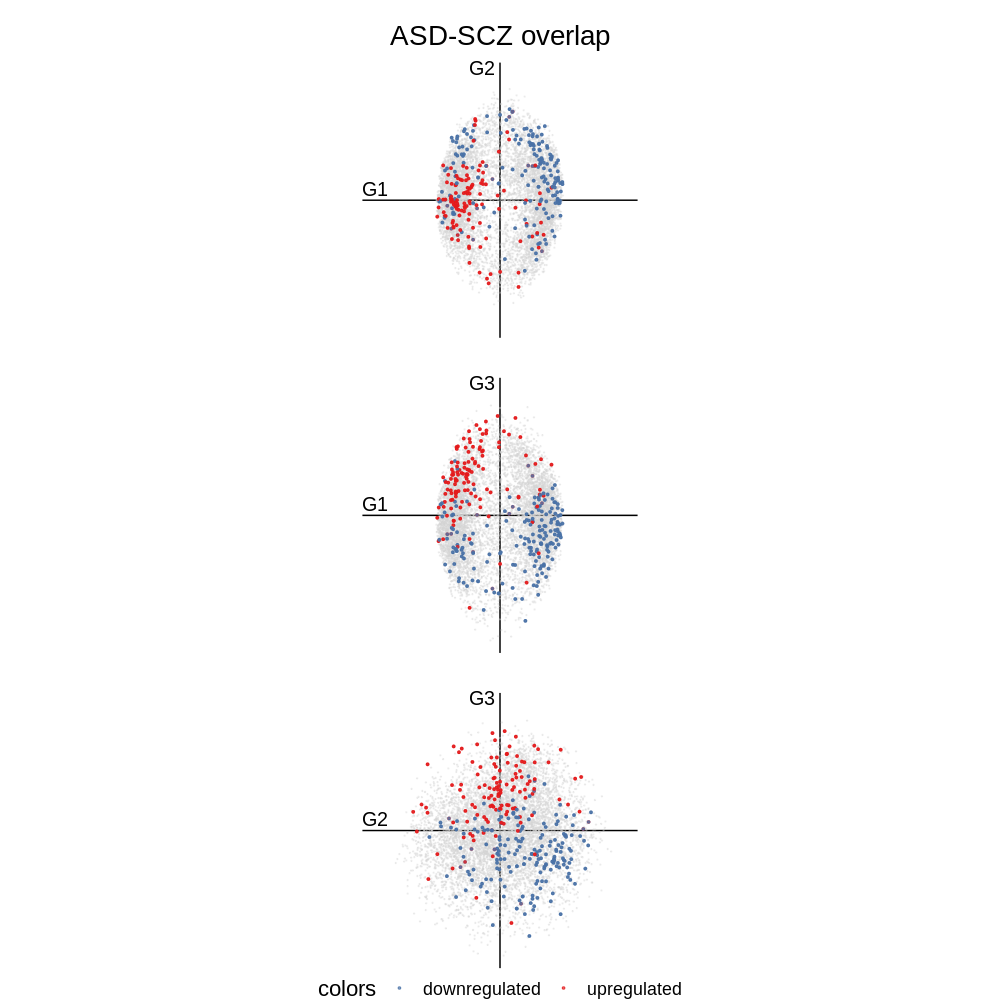

In [175]:
%%R -i weights_clusters -w 10 -h 10 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, colors=rev(brewer.set1(10)[1:2]), title='')
# plot_weight_scatters_with_labels(weights_labels %>% filter(cluster!='downregulated'), colors=brewer.set1(10)[1], title='Upregulated') |
# plot_weight_scatters_with_labels(weights_labels %>% filter(cluster!='upregulated'), colors=brewer.set1(10)[2], title='Downregulated')

In [176]:
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    if disorder == 'none':
        continue    
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [178]:
(pd.concat(disorder_enrichments, axis=1).loc[pd.IndexSlice[:,range(20)], :].sort_index(0)
)

ASD-SCZ overlap  \
                                                               term   
downregulated 0                                    cation transport   
              1                      proton transmembrane transport   
              2                      cation transmembrane transport   
              3                                       ion transport   
              4                         ion transmembrane transport   
              5           regulation of ion transmembrane transport   
              6                             transmembrane transport   
              7        regulation of cation transmembrane transport   
              8                                 aerobic respiration   
              9                            tricarboxylic acid cycle   
              10     generation of precursor metabolites and energy   
              11              regulation of transmembrane transport   
              12                        regulation of ion transport   
              13                               cellular respiration   
              14              inorganic ion transmembrane transport   
              15                                   export from cell   
              16               regulation of nmda receptor activity   
              17                                          secretion   
              18                                 synaptic signaling   
              19                                     signal release   
upregulated   0                            regulation of cell death   
              1                   negative regulation of cell death   
              2                               programmed cell death   
              3           regulation of apoptotic signaling pathway   
              4              response to oxygen containing compound   
              5   regulation of multicellular organismal develop...   
              6         regulation of cell population proliferation   
              7                     regulation of catabolic process   
              8                      circulatory system development   
              9                                 biological adhesion   
              10                                 cell cell adhesion   
              11                                     cell migration   
              12    regulation of intracellular signal transduction   
              13                            vasculature development   
              14  negative regulation of apoptotic signaling pat...   
              15                                      wound healing   
              16                   regulation of response to stress   
              17                    response to endogenous stimulus   
              18    regulation of epithelial cell apoptotic process   
              19                                         locomotion   

                                          
                             p       fdr  
downregulated 0   2.228929e-07  0.000574  
              1   5.949055e-07  0.000765  
              2   1.647563e-06  0.000929  
              3   1.801534e-06  0.000929  
              4   1.805522e-06  0.000929  
              5   1.398361e-05  0.005997  
              6   1.937788e-05  0.006732  
              7   2.093262e-05  0.006732  
              8   2.429771e-05  0.006946  
              9   3.143257e-05  0.007648  
              10  3.269476e-05  0.007648  
              11  4.609801e-05  0.009884  
              12  5.912421e-05  0.011702  
              13  7.101462e-05  0.013051  
              14  9.412621e-05  0.016146  
              15  1.439925e-04  0.023156  
              16  1.702857e-04  0.025773  
              17  2.022415e-04  0.028609  
              18  2.224907e-04  0.028609  
              19  2.285306e-04  0.028609  
upregulated   0   7.951233e-10  0.000002  
              1   3.722370e-09  0.000005  
              2   6.802432e-09  0.000

## Clustering

In [127]:
from sklearn.cluster import KMeans, AgglomerativeClustering

clust = KMeans(n_clusters=2, random_state=1)
# clust = AgglomerativeClustering(n_clusters=2)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['log2FC']>0] # filter up/dn
    weights_disorder = weights_disorder.loc[lambda x: x['label']==d, [0,1,2]]
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

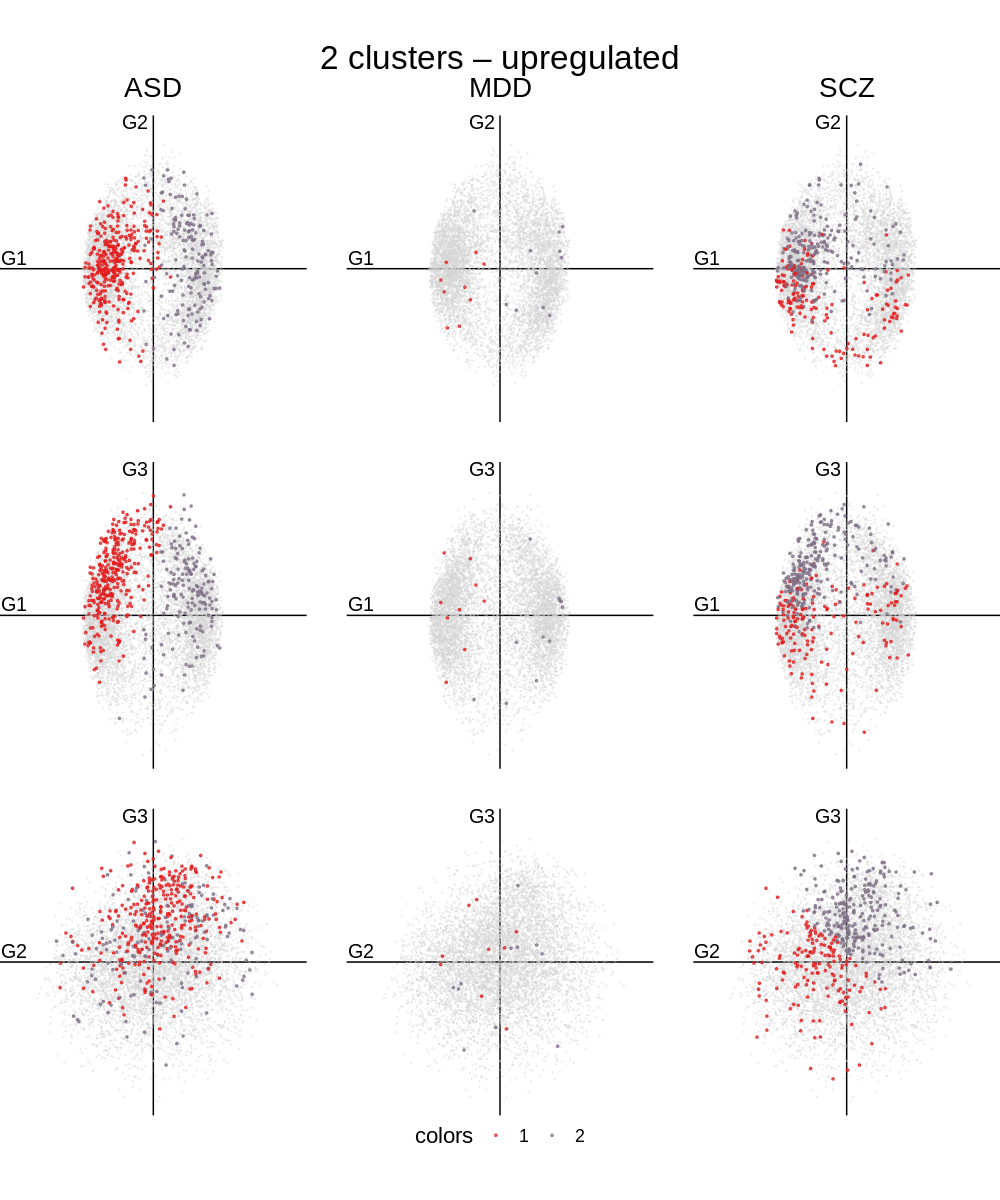

In [128]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, "2 clusters – upregulated", colors=brewer.set1(10)[c(1,4)])
# plot_weight_scatters_with_labels(weights_clusters, "2 clusters – downregulated", colors=brewer.set1(10)[c(2,3)])

In [363]:
cluster_disorder_names = {
    'ASD': {'1':'G1+/G2+', '2':'G1-/G3-', '3':'G1-/G3+', '4':'G1+/G2-'},
    'MDD': {'1':'G1+/G2-', '2':'G1-/G3-', '3':'G1-/G3+', '4':'G1+/G2+'},
    'SCZ': {'1':'G1+/G2+', '2':'G1-/G3+', '3':'G1-/G3-', '4':'G1+/G2-'}
}

altered = []
for g, df in weights_clusters.groupby('label'):
    if g=='none':
        continue
    df = df.replace({'cluster': cluster_disorder_names[g]})
    altered.append(df)

altered.append(weights_clusters.query("label=='none'"))
    
weights_clusters = pd.concat(altered)    
weights_clusters#.loc[lambda x: x['label']=='ASD']

label         0         1         2  cluster
AARS     ASD  0.009905  0.014900 -0.011481  G1+/G2+
ABCA1    ASD -0.009050 -0.014071  0.013329  G1-/G3+
ABCB10   ASD  0.011837 -0.008562 -0.003140  G1+/G2-
ABCB6    ASD -0.011519  0.010344 -0.007273  G1-/G3-
ABCC12   ASD -0.004719  0.013053 -0.029257  G1-/G3-
...      ...       ...       ...       ...      ...
ZSWIM4  none  0.015578  0.003531 -0.001302      NaN
ZSWIM7  none -0.008451  0.015129  0.001073      NaN
ZSWIM9  none -0.009991  0.000473  0.002506      NaN
ZWINT   none -0.012440 -0.008334  0.000574      NaN
ZZEF1   none  0.013004 -0.012945  0.009701      NaN

[8321 rows x 5 columns]

In [319]:
(weights_clusters.query("label=='ASD'")
 .assign(overlap=lambda x: np.isin(x.index, weights_clusters.query("label=='SCZ'").index))
 .groupby('cluster').agg(['sum','count'])
 .loc[:,'overlap']
 .assign(pct=lambda x: x['sum']/x['count'])
)

sum  count       pct
cluster                      
G1+/G2+   88    303  0.290429
G1+/G2-   57    247  0.230769
G1-/G3+   98    324  0.302469
G1-/G3-   64    263  0.243346

In [320]:
cluster_genes = {}
for d in ['ASD', 'SCZ']:
    disorder_clusters = weights_clusters.loc[lambda x: x['label']==d].sort_values(['cluster', 0])
    disorder_cluster_genes = {}
    for c in disorder_clusters['cluster'].unique():
        disorder_cluster_genes[c] = pd.Series(disorder_clusters.loc[lambda x: x['cluster']==c].index)
    cluster_genes[d] = pd.concat(disorder_cluster_genes, axis=1)
cluster_genes = pd.concat(cluster_genes, axis=1)
cluster_genes.to_csv("../outputs/clusters_kmeans4.csv")

In [135]:
# sig_genes = list(weights_clusters.index.unique())
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    if disorder == 'none':
        continue
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [136]:
pd.concat(disorder_enrichments, axis=1).loc[pd.IndexSlice[:,range(20)], pd.IndexSlice[['ASD','SCZ'],:]].sort_index(0)

ASD                \
                                                   term             p   
1 0                                 biological adhesion  4.033881e-17   
  1         regulation of cell population proliferation  3.255226e-16   
  2                                   t cell activation  1.672246e-15   
  3                 regulation of immune system process  1.009112e-13   
  4                                     immune response  1.064607e-13   
  5                                  tube morphogenesis  2.256504e-13   
  6                          blood vessel morphogenesis  3.365129e-13   
  7                               lymphocyte activation  4.533910e-13   
  8   biological process involved in interspecies in...  7.246007e-13   
  9                                     cell activation  8.803968e-13   
  10                    regulation of t cell activation  1.189105e-12   
  11  anatomical structure formation involved in mor...  1.924273e-12   
  12                                 cell cell adhesion  2.216379e-12   
  13                       leukocyte cell cell adhesion  2.334297e-12   
  14                        regulation of cell adhesion  2.816269e-12   
  15                            vasculature development  3.133339e-12   
  16                                cytokine production  3.710772e-12   
  17  positive regulation of leukocyte cell cell adh...  9.502046e-12   
  18                                   tube development  9.589918e-12   
  19                      regulation of immune response  1.132501e-11   
2 0                    regulation of response to stress  5.866120e-10   
  1                                    defense response  1.241452e-09   
  2                               inflammatory response  3.245473e-08   
  3   regulation of multicellular organismal develop...  5.475962e-08   
  4                                   response to lipid  8.959313e-08   
  5         negative regulation of response to stimulus  1.314291e-07   
  6   biological process involved in interspecies in...  1.472239e-07   
  7                  regulation of cell differentiation  2.478175e-07   
  8         regulation of response to external stimulus  3.162760e-07   
  9                        response to abiotic stimulus  3.688034e-07   
  10        negative regulation of biosynthetic process  1.079530e-06   
  11                 maintenance of blood brain barrier  1.398193e-06   
  12                    response to endogenous stimulus  1.515795e-06   
  13                                 tissue development  1.672670e-06   
  14                     regulation of defense response  1.677892e-06   
  15                               response to wounding  1.781226e-06   
  16  negative regulation of intracellular signal tr...  2.670679e-06   
  17                                          ovulation  3.673529e-06   
  18                       muscle structure development  3.954996e-06   
  19                         circulatory system process  4.387154e-06   

                                                                  SCZ  \
               fdr                                               term   
1 0   1.570793e-13  positive regulation of multicellular organisma...   
  1   6.337925e-13                         post embryonic development   
  2   2.170576e-12              retina development in camera type eye   
  3   8.291156e-11     positive regulation of stem cell proliferation   
  4   8.291156e-11  negative regulation of amyloid precursor prote...   
  5   1.464471e-10              regulation of stem cell proliferation   
  6   1.871973e-10                            stem cell proliferation   
  7   2.206881e-10       positive regulation of rna metabolic process   
  8   3.135106e-10                multicellular organism reproduction   
  9   3.428265e-10         regulation of phosphorus metabolic process   
  10  4.209431e-10                                    phosphorylation   
  11  6.244267e-10                  

## KMeans clustering - 2 clusters

In [365]:
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=2, random_state=1)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

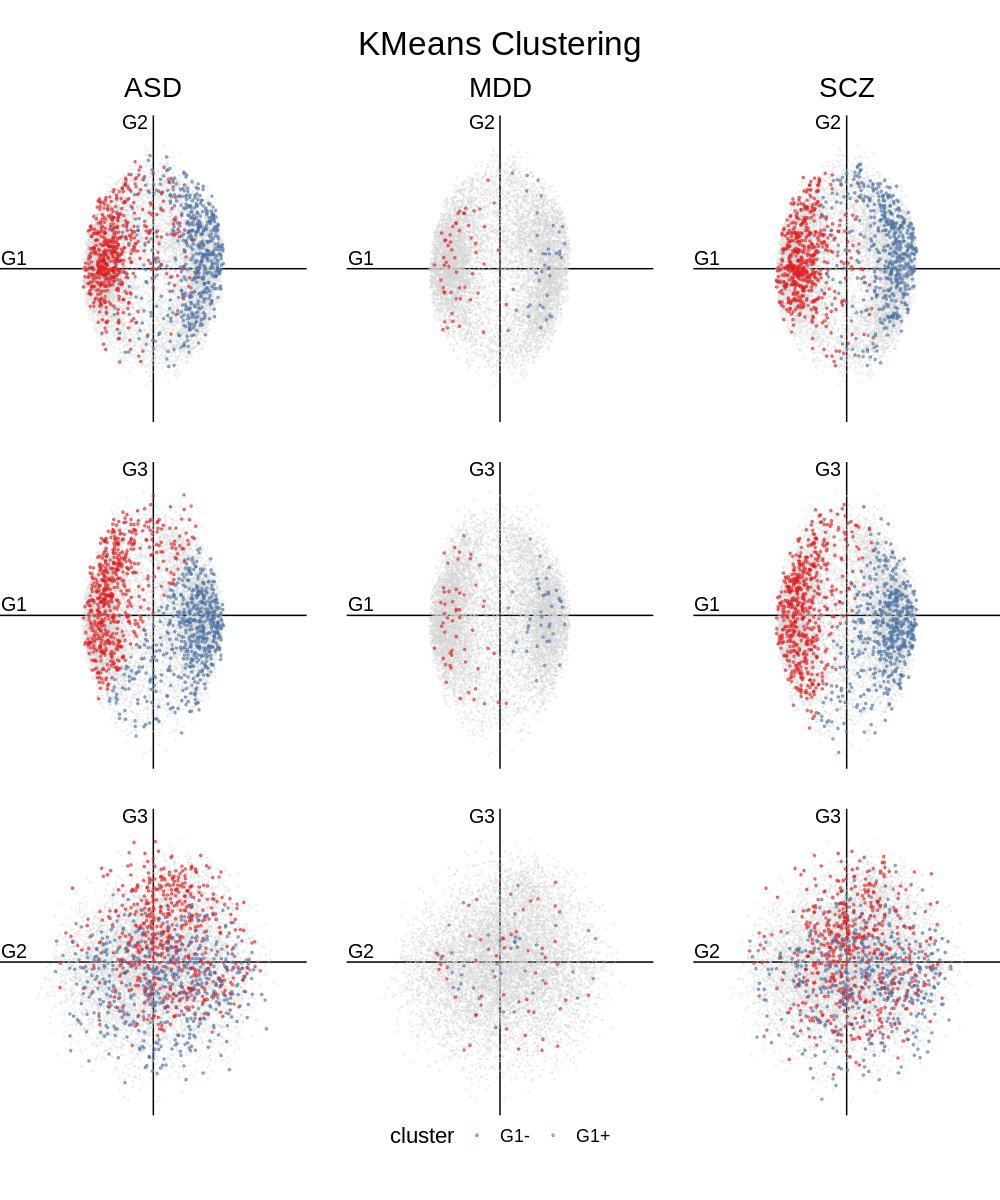

In [368]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, "KMeans Clustering")

In [366]:
cluster_disorder_names = {
    'ASD': {'1':'G1+', '2':'G1-'},
    'MDD': {'1':'G1+', '2':'G1-'},    
    'SCZ': {'1':'G1-', '2':'G1+'}
}

altered = []
for g, df in weights_clusters.groupby('label'):
    if g=='none':
        continue
    df = df.replace({'cluster': cluster_disorder_names[g]})
    altered.append(df)
    
altered.append(weights_clusters.query("label=='none'"))    

weights_clusters = pd.concat(altered)    
weights_clusters#.loc[lambda x: x['label']=='ASD']

label         0         1         2 cluster
AARS     ASD  0.009905  0.014900 -0.011481     G1+
ABCA1    ASD -0.009050 -0.014071  0.013329     G1-
ABCB10   ASD  0.011837 -0.008562 -0.003140     G1+
ABCB6    ASD -0.011519  0.010344 -0.007273     G1-
ABCC12   ASD -0.004719  0.013053 -0.029257     G1+
...      ...       ...       ...       ...     ...
ZSWIM4  none  0.015578  0.003531 -0.001302     NaN
ZSWIM7  none -0.008451  0.015129  0.001073     NaN
ZSWIM9  none -0.009991  0.000473  0.002506     NaN
ZWINT   none -0.012440 -0.008334  0.000574     NaN
ZZEF1   none  0.013004 -0.012945  0.009701     NaN

[8321 rows x 5 columns]

In [297]:
(weights_clusters.query("label=='ASD'")
 .assign(overlap=lambda x: np.isin(x.index, weights_clusters.query("label=='SCZ'").index))
 .groupby('cluster').agg(['sum','count'])
 .loc[:,'overlap']
 .assign(pct=lambda x: x['sum']/x['count'])
)

sum  count       pct
cluster                      
G1+      151    559  0.270125
G1-      156    578  0.269896

In [300]:
cluster_genes = {}
for d in ['ASD', 'SCZ']:
    disorder_clusters = weights_clusters.loc[lambda x: x['label']==d].sort_values(['cluster', 0])
    disorder_cluster_genes = {}
    for c in disorder_clusters['cluster'].unique():
        disorder_cluster_genes[c] = pd.Series(disorder_clusters.loc[lambda x: x['cluster']==c].index)
    cluster_genes[d] = pd.concat(disorder_cluster_genes, axis=1)
cluster_genes = pd.concat(cluster_genes, axis=1)

In [301]:
sig_genes = list(weights_clusters.index.unique())
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [303]:
pd.concat(disorder_enrichments, axis=1).loc[pd.IndexSlice[:,range(20)], pd.IndexSlice[['ASD','SCZ'],:]].sort_index(0)
 # .loc[['G1-/G3+','G1-/G3-']]
#.to_csv("../outputs/disorder_enrichments.csv")
# pd.concat(cluster_enrichments)
# disorder_enrichments['ASD'].loc[pd.IndexSlice[:,range(10)], :]

ASD                \
                                                     term             p   
G1+ 0                      proton transmembrane transport  5.628390e-06   
    1                                 aerobic respiration  5.503198e-05   
    2                                    export from cell  6.248139e-05   
    3                                  synaptic signaling  8.980746e-05   
    4                                cellular respiration  1.005675e-04   
    5                                    cation transport  2.050801e-04   
    6                             transmembrane transport  2.094604e-04   
    7                                       ion transport  2.513268e-04   
    8   protein modification by small protein conjugat...  3.090046e-04   
    9                                      signal release  3.145297e-04   
    10                            regulation of transport  3.459995e-04   
    11                              atp metabolic process  3.624418e-04   
    12                        nitrogen compound transport  4.670441e-04   
    13                regulation of mitochondrial fission  5.041351e-04   
    14       regulation of the force of heart contraction  5.041351e-04   
    15                         neurotransmitter transport  5.693511e-04   
    16                    regulation of muscle adaptation  6.137324e-04   
    17                               sodium ion transport  6.333898e-04   
    18                         neurotransmitter secretion  6.621497e-04   
    19                   regulation of response to stress  7.227615e-04   
G1- 0         regulation of cell population proliferation  3.248644e-12   
    1                                 biological adhesion  1.217118e-11   
    2                                   t cell activation  6.126786e-11   
    3                        leukocyte cell cell adhesion  5.373531e-10   
    4           positive regulation of cell cell adhesion  8.282042e-10   
    5                                    defense response  1.165724e-09   
    6                     regulation of t cell activation  1.526229e-09   
    7                    regulation of cell cell adhesion  1.722422e-09   
    8                         regulation of cell adhesion  2.087718e-09   
    9                positive regulation of cell adhesion  3.847015e-09   
    10  positive regulation of leukocyte cell cell adh...  4.532552e-09   
    11                              lymphocyte activation  4.548280e-09   
    12                                    immune response  7.918418e-09   
    13  positive regulation of cell population prolife...  1.073803e-08   
    14                  negative regulation of cell death  1.082277e-08   
    15                                 cell cell adhesion  1.307420e-08   
    16                regulation of immune system process  1.829094e-08   
    17                                    cell activation  1.898240e-08   
    18                         blood vessel morphogenesis  3.507430e-08   
    19                                 tube morphogenesis  3.634109e-08   

                                                                    SCZ  \
                 fdr                                               term   
G1+ 0   2.433716e-02                                    phosphorylation   
    1   8.697074e-02    regulation of intracellular signal transduction   
    2   8.697074e-02               cell substrate junction organization   
    3   8.697074e-02                                   export from cell   
    4   8.697074e-02                            focal adhesion assembly   
    5   1.293867e-01                              programmed cell death   
    6   1.293867e-01                   positive regulation of autophagy   
    7   1.305999e-01                   negative regulation of signaling   
    8   1.305999e-01          positive regulation of molecular function   
    9   1.305999e-01                            catecholamine secretion   
   

## KMeans clustering - more clusters

In [417]:
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=8, random_state=1)

weights_clusters = {}
for d in ['All DS5']:
    weights_disorder = weights_labels.drop('label', axis=1)#.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

# weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

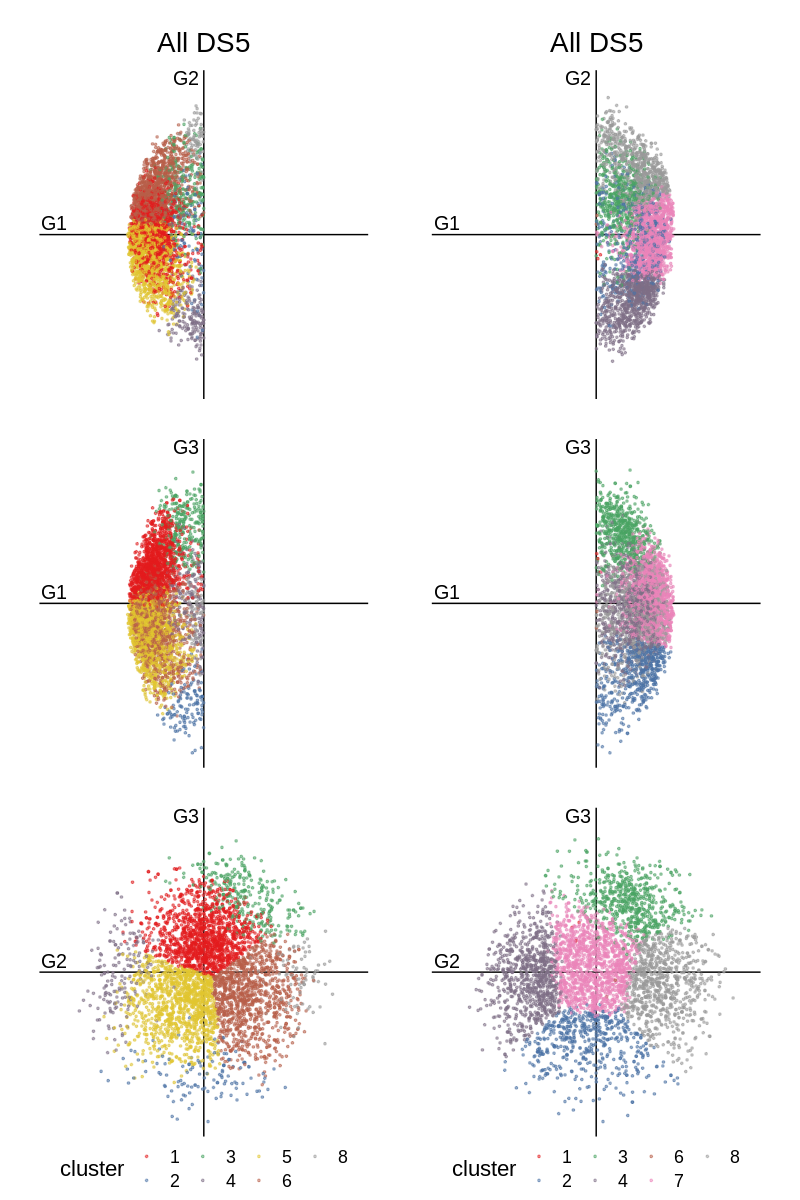

In [425]:
%%R -i weights_clusters -w 8 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
# plot_weight_scatters_with_labels(weights_clusters, "")
plot_weight_scatters_with_labels(weights_clusters %>% filter(`0` < 0), title="", colors=brewer.set1(10)[c(1:4,7,8,10)]) | 
plot_weight_scatters_with_labels(weights_clusters %>% filter(`0` > 0), title="", colors=brewer.set1(10)[c(1:4,8:10)])

In [381]:
cluster_disorder_names = {
    'All DS5': {'1':'G1+/G2+', '2':'G1-/G3+', '3':'G1-/G3-', '4':'G1+/G2-'}
}

altered = []
for g, df in weights_clusters.groupby('label'):
    if g=='none':
        continue
    df = df.replace({'cluster': cluster_disorder_names[g]})
    altered.append(df)
    
altered.append(weights_clusters.query("label=='none'"))    

weights_clusters = pd.concat(altered)    
weights_clusters#.loc[lambda x: x['label']=='ASD']

label         0         1         2  cluster
A1BG      All DS5 -0.015451 -0.004935  0.000699  G1-/G3-
A1BG-AS1  All DS5 -0.011982 -0.001214 -0.016185  G1-/G3-
AAAS      All DS5  0.011610  0.004924  0.002747  G1+/G2+
AAED1     All DS5 -0.013839 -0.000380  0.008323  G1-/G3+
AAGAB     All DS5 -0.005098  0.019884 -0.014751  G1+/G2+
...           ...       ...       ...       ...      ...
ZSWIM9    All DS5 -0.009991  0.000473  0.002506  G1-/G3-
ZWINT     All DS5 -0.012440 -0.008334  0.000574  G1-/G3-
ZYX       All DS5  0.017013  0.005947 -0.003734  G1+/G2+
ZZEF1     All DS5  0.013004 -0.012945  0.009701  G1+/G2-
ZZZ3      All DS5 -0.010819 -0.004823  0.001800  G1-/G3-

[8321 rows x 5 columns]

In [297]:
(weights_clusters.query("label=='ASD'")
 .assign(overlap=lambda x: np.isin(x.index, weights_clusters.query("label=='SCZ'").index))
 .groupby('cluster').agg(['sum','count'])
 .loc[:,'overlap']
 .assign(pct=lambda x: x['sum']/x['count'])
)

sum  count       pct
cluster                      
G1+      151    559  0.270125
G1-      156    578  0.269896

In [300]:
cluster_genes = {}
for d in ['ASD', 'SCZ']:
    disorder_clusters = weights_clusters.loc[lambda x: x['label']==d].sort_values(['cluster', 0])
    disorder_cluster_genes = {}
    for c in disorder_clusters['cluster'].unique():
        disorder_cluster_genes[c] = pd.Series(disorder_clusters.loc[lambda x: x['cluster']==c].index)
    cluster_genes[d] = pd.concat(disorder_cluster_genes, axis=1)
cluster_genes = pd.concat(cluster_genes, axis=1)

In [426]:
sig_genes = list(weights_clusters.index.unique())
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [427]:
pd.concat(disorder_enrichments, axis=1).loc[pd.IndexSlice[:,range(10)], :].sort_index(0).unstack(0)
 # .loc[['G1-/G3+','G1-/G3-']]
#.to_csv("../outputs/disorder_enrichments.csv")
# pd.concat(cluster_enrichments)
# disorder_enrichments['ASD'].loc[pd.IndexSlice[:,range(10)], :]

All DS5  \
                                                term   
                                                   1   
0                                    immune response   
1                            cytoplasmic translation   
2                             innate immune response   
3                regulation of immune system process   
4                       stress response to metal ion   
5                                    cell activation   
6  biological process involved in interspecies in...   
7                       myeloid leukocyte activation   
8                       detoxification of copper ion   
9                      regulation of immune response   

                                           \
                                            
                                        2   
0                      synaptic signaling   
1          regulation of circadian rhythm   
2                        circadian rhythm   
3                      cell morphogenesis   
4                        rhythmic process   
5             regulation of ion transport   
6                     cell cell signaling   
7                      neuron development   
8                 cell part morphogenesis   
9  regulation of trans synaptic signaling   

                                                      \
                                                       
                                                   3   
0                            vasculature development   
1                         blood vessel morphogenesis   
2  antigen processing and presentation of endogen...   
3  antigen processing and presentation of peptide...   
4                                biological adhesion   
5  transmembrane receptor protein serine threonin...   
6                                   tube development   
7  antigen processing and presentation of endogen...   
8  anatomical structure formation involved in mor...   
9                                 tube morphogenesis   

                                                      \
                                                       
                                                   4   
0                             chromatin organization   
1                               histone modification   
2                            chromosome organization   
3                       peptidyl lysine modification   
4        negative regulation of biosynthetic process   
5                             mrna metabolic process   
6                                    mrna processing   
7                                         dna repair   
8                        peptidyl lysine methylation   
9  negative regulation of nucleobase containing c...   

                                                  \
                                                   
                                               5   
0                             synaptic signaling   
1  regulation of postsynaptic membrane potential   
2         regulation of trans synaptic signaling   
3    chemical synaptic transmission postsynaptic   
4           glutamate receptor signaling pathway   
5                            cell cell signaling   
6                long term synaptic potentiation   
7                           synapse organization   
8                                       behavior   
9    regulation of synapse structure or activity   

                                                      \
                                                       
                                                   6   
0                        sterol biosynthetic process   
1                                ribosome biogenesis   
2                                     macroautophagy   
3  modification dependent macromolecule catabolic...   
4                 cellular protein catabolic process   
5      organic hydroxy compound biosynthetic process   
6               ribonucleoprotein complex biogenesis   
7                           sterol 

## Direct partioning of all DS5 genes

G1 +-

In [372]:
# weights_clusters = (weights_labels
#  .assign(label = 'All DS5 genes')
#  .assign(cluster = lambda x: np.select(
#      condlist = [(x[0]>0), 
#                  (x[0]<0)
#                 ],
#      choicelist = ['G1+', 'G1-'])
#         )
# )
# weights_clusters

0         1         2          label cluster
A1BG     -0.015451 -0.004935  0.000699  All DS5 genes     G1-
A1BG-AS1 -0.011982 -0.001214 -0.016185  All DS5 genes     G1-
AAAS      0.011610  0.004924  0.002747  All DS5 genes     G1+
AAED1    -0.013839 -0.000380  0.008323  All DS5 genes     G1-
AAGAB    -0.005098  0.019884 -0.014751  All DS5 genes     G1-
...            ...       ...       ...            ...     ...
ZSWIM9   -0.009991  0.000473  0.002506  All DS5 genes     G1-
ZWINT    -0.012440 -0.008334  0.000574  All DS5 genes     G1-
ZYX       0.017013  0.005947 -0.003734  All DS5 genes     G1+
ZZEF1     0.013004 -0.012945  0.009701  All DS5 genes     G1+
ZZZ3     -0.010819 -0.004823  0.001800  All DS5 genes     G1-

[8321 rows x 5 columns]

Four clusters

In [369]:
# weights_clusters = (weights_labels
#  .assign(label = 'All DS5 genes')
#  .assign(cluster = lambda x: np.select(
#      condlist = [(x[0]>0) & (x[1]>0), 
#                  (x[0]>0) & (x[1]<0), 
#                  (x[0]<0) & (x[2]>0), 
#                  (x[0]<0) & (x[2]<0)
#                 ],
#      choicelist = ['G1+/G2+', 'G1+/G2-', 'G1-/G3+', 'G1-/G3-'])
#         )
# )
# weights_clusters

0         1         2          label  cluster
A1BG     -0.015451 -0.004935  0.000699  All DS5 genes  G1-/G3+
A1BG-AS1 -0.011982 -0.001214 -0.016185  All DS5 genes  G1-/G3-
AAAS      0.011610  0.004924  0.002747  All DS5 genes  G1+/G2+
AAED1    -0.013839 -0.000380  0.008323  All DS5 genes  G1-/G3+
AAGAB    -0.005098  0.019884 -0.014751  All DS5 genes  G1-/G3-
...            ...       ...       ...            ...      ...
ZSWIM9   -0.009991  0.000473  0.002506  All DS5 genes  G1-/G3+
ZWINT    -0.012440 -0.008334  0.000574  All DS5 genes  G1-/G3+
ZYX       0.017013  0.005947 -0.003734  All DS5 genes  G1+/G2+
ZZEF1     0.013004 -0.012945  0.009701  All DS5 genes  G1+/G2-
ZZZ3     -0.010819 -0.004823  0.001800  All DS5 genes  G1-/G3+

[8321 rows x 5 columns]

Eight clusters

In [401]:
weights_clusters = weights_labels.assign(label = 'All DS5 genes')
for G in [0,1,2]:
    weights_clusters[f'G{G+1}_sign'] = ['+' if weight>0 else '-' for weight in weights_clusters[G]]
weights_clusters = weights_clusters.assign(cluster = lambda x: x['G1_sign'] + x['G2_sign'] + x['G3_sign'])
    
weights_clusters

0         1         2          label G1_sign G2_sign G3_sign  \
A1BG     -0.015451 -0.004935  0.000699  All DS5 genes       -       -       +   
A1BG-AS1 -0.011982 -0.001214 -0.016185  All DS5 genes       -       -       -   
AAAS      0.011610  0.004924  0.002747  All DS5 genes       +       +       +   
AAED1    -0.013839 -0.000380  0.008323  All DS5 genes       -       -       +   
AAGAB    -0.005098  0.019884 -0.014751  All DS5 genes       -       +       -   
...            ...       ...       ...            ...     ...     ...     ...   
ZSWIM9   -0.009991  0.000473  0.002506  All DS5 genes       -       +       +   
ZWINT    -0.012440 -0.008334  0.000574  All DS5 genes       -       -       +   
ZYX       0.017013  0.005947 -0.003734  All DS5 genes       +       +       -   
ZZEF1     0.013004 -0.012945  0.009701  All DS5 genes       +       -       +   
ZZZ3     -0.010819 -0.004823  0.001800  All DS5 genes       -       -       +   

         cluster  
A1BG         --+  
A1BG-AS1     ---  
AAAS         +++  
AAED1        --+  
AAGAB        -+-  
...          ...  
ZSWIM9       -++  
ZWINT        --+  
ZYX          ++-  
ZZEF1        +-+  
ZZZ3         --+  

[8321 rows x 8 columns]

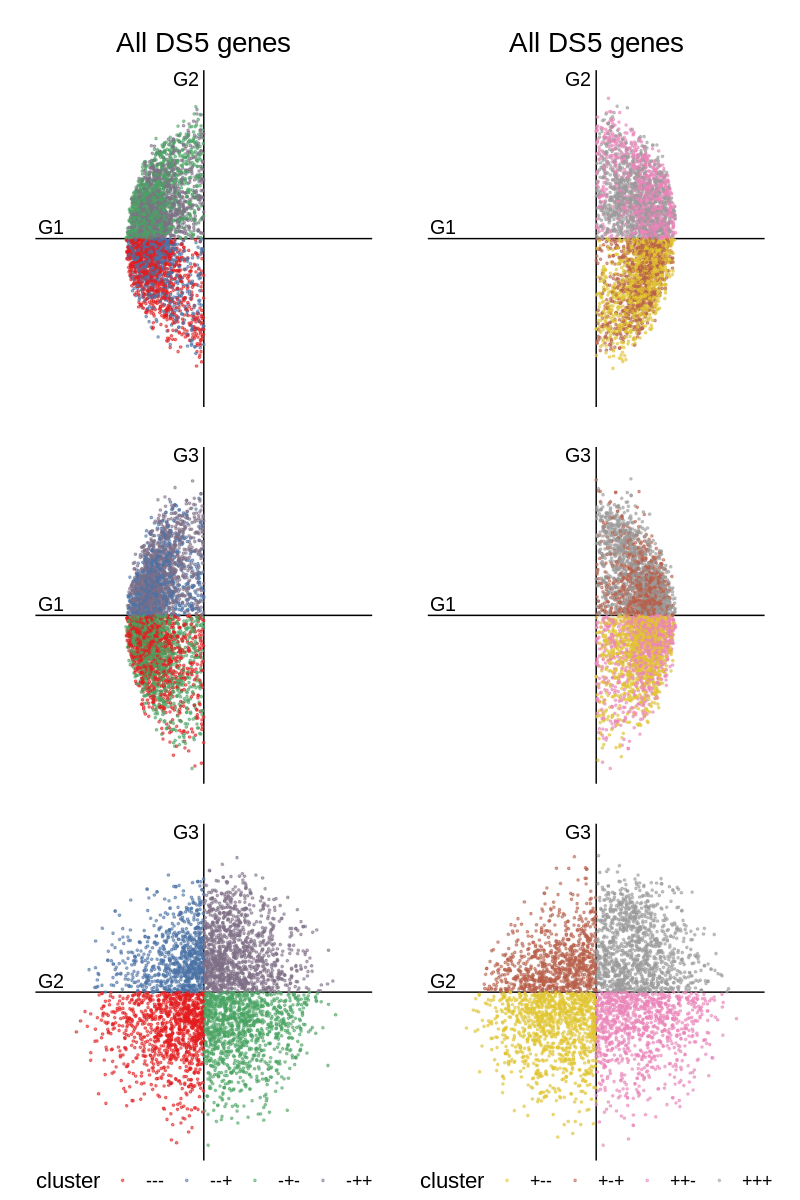

In [409]:
%%R -i weights_clusters -w 8 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters %>% filter(G1_sign == '-'), title="") | 
plot_weight_scatters_with_labels(weights_clusters %>% filter(G1_sign == '+'), title="", colors=brewer.set1(10)[7:10])

In [410]:
# sig_genes = list(weights_clusters.index.unique())
all_genes = list(weights_labels.index.unique())
background_genes = all_genes

disorder_enrichments = {}
for disorder, disorder_df in weights_clusters.groupby('label'):
    cluster_enrichments = {}
    for cluster, cluster_df in disorder_df.groupby('cluster'):
        genes_in_cluster = list(cluster_df.index)
        cluster_enrichments[cluster] = get_target_enrichments(genes_in_cluster, background_genes)[['term','p','fdr']].reset_index(drop=True)
    disorder_enrichments[disorder] = pd.concat(cluster_enrichments)

In [416]:
pd.concat(disorder_enrichments, axis=1).loc[pd.IndexSlice[:,range(10)], :].sort_index(0).unstack(0)#.reorder_levels([0,2,1],axis=1).sort_index(axis=1)

All DS5 genes  \
                                             term   
                                              +++   
0            organic acid transmembrane transport   
1                        lymph vessel development   
2                         organic anion transport   
3                          organic acid transport   
4              smooth muscle cell differentiation   
5                               vitamin transport   
6                       carboxylic acid transport   
7                         vasculature development   
8                                tube development   
9  ventricular trabecula myocardium morphogenesis   

                                                      \
                                                       
                                                 ++-   
0              inorganic ion transmembrane transport   
1                         mitochondrion organization   
2                     cation transmembrane transport   
3                        ion transmembrane transport   
4                         autophagy of mitochondrion   
5  energy derivation by oxidation of organic comp...   
6                               cellular respiration   
7                           translational initiation   
8                            transmembrane transport   
9            inorganic anion transmembrane transport   

                                                      \
                                                       
                                                 +-+   
0                             chromatin organization   
1                            chromosome organization   
2                                     rna processing   
3                               histone modification   
4                              dna metabolic process   
5           cellular response to dna damage stimulus   
6                                         dna repair   
7                                       rna splicing   
8  detection of chemical stimulus involved in sen...   
9                             mrna metabolic process   

                                                      \
                                                       
                                                 +--   
0                             chromatin organization   
1                            chromosome organization   
2                       peptidyl lysine modification   
3                               histone modification   
4                               chromatin remodeling   
5  positive regulation of nucleobase containing c...   
6                  intraciliary retrograde transport   
7  negative regulation of nucleobase containing c...   
8       positive regulation of rna metabolic process   
9        negative regulation of biosynthetic process   

                                                      \
                                                       
                                                 -++   
0                                    immune response   
1                        leukocyte mediated immunity   
2                            lipid metabolic process   
3              detection of external biotic stimulus   
4               positive regulation of cell adhesion   
5  biological process involved in interspecies in...   
6                            immune effector process   
7                regulation of immune system process   
8                                biological adhesion   
9                                    cell activation   

                                                      \
                                                       
                                                 -+-   
0                        nitrogen compound transport   
1              establishment of protein localization   
2  modification dependent macromolecule catabolic...   
3                                ribosome biogenesis   
4                            axo dendr

## Hierarchical clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(n_clusters=4)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

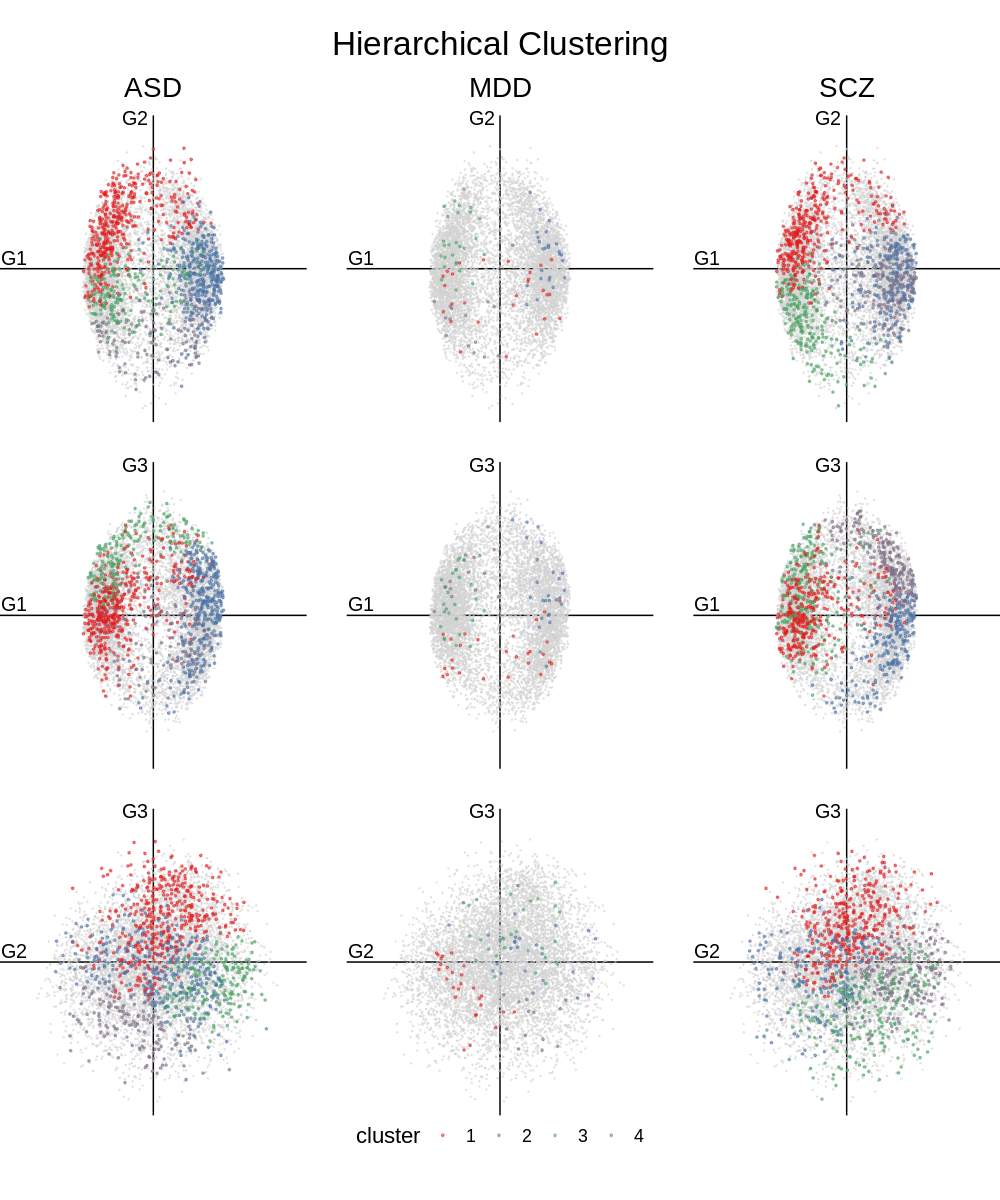

In [69]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, 'Hierarchical Clustering')

## Spectral clustering

In [74]:
from sklearn.cluster import SpectralClustering

clust = SpectralClustering(n_clusters=4)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

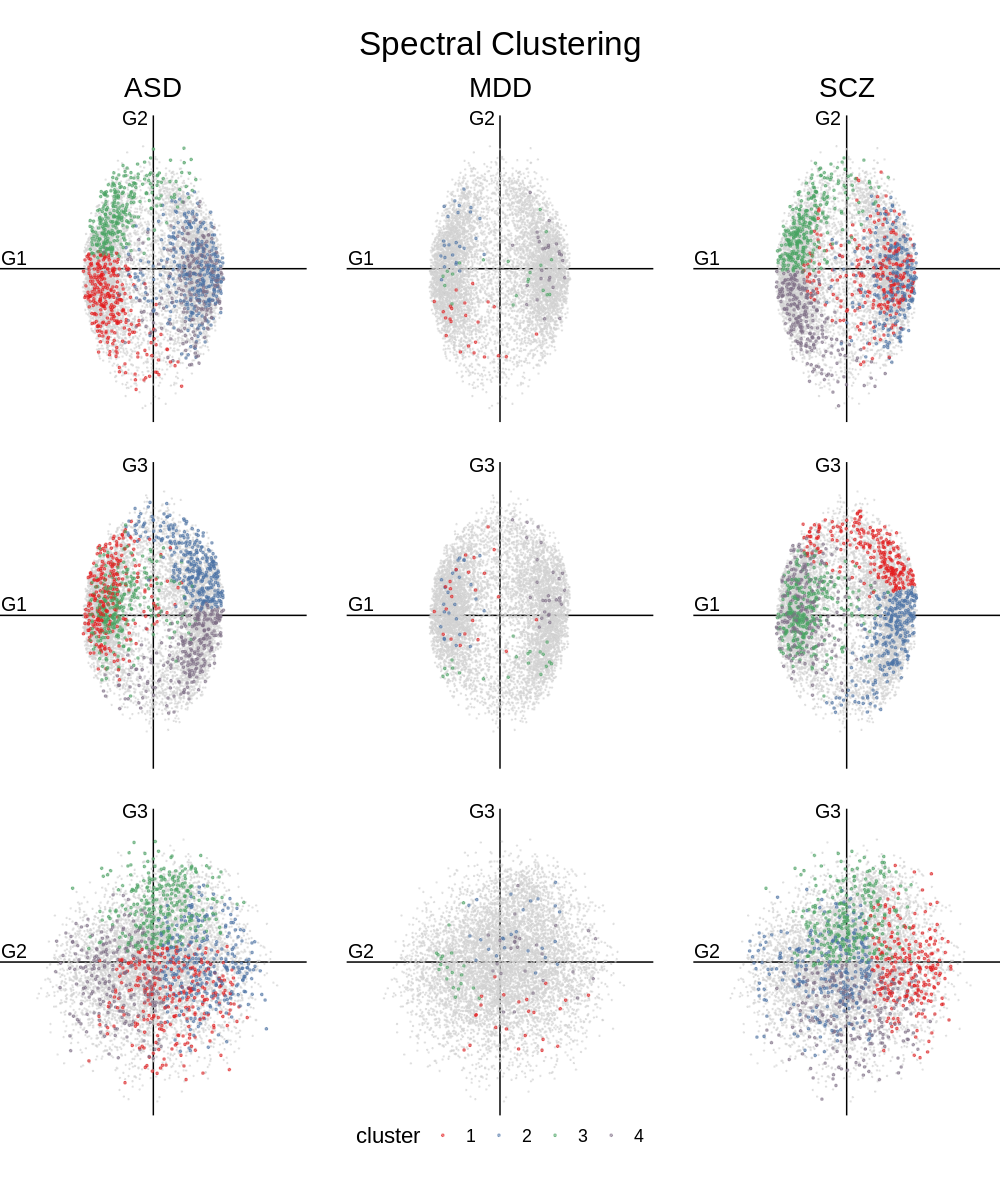

In [75]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, "Spectral Clustering")

## Rare genes

In [195]:
rare_genes = get_rare_genes()

In [196]:
weights_labels = weights.join(rare_genes.set_index('gene')).fillna({'label':'NA'})
weights_labels

0         1         2 label
A1BG     -0.015451 -0.004935  0.000699    NA
A1BG-AS1 -0.011982 -0.001214 -0.016185    NA
AAAS      0.011610  0.004924  0.002747    NA
AAED1    -0.013839 -0.000380  0.008323    NA
AAGAB    -0.005098  0.019884 -0.014751    NA
...            ...       ...       ...   ...
ZSWIM9   -0.009991  0.000472  0.002506    NA
ZWINT    -0.012440 -0.008334  0.000574    NA
ZYX       0.017013  0.005947 -0.003734    NA
ZZEF1     0.013004 -0.012944  0.009701    NA
ZZZ3     -0.010819 -0.004823  0.001800    NA

[7975 rows x 4 columns]

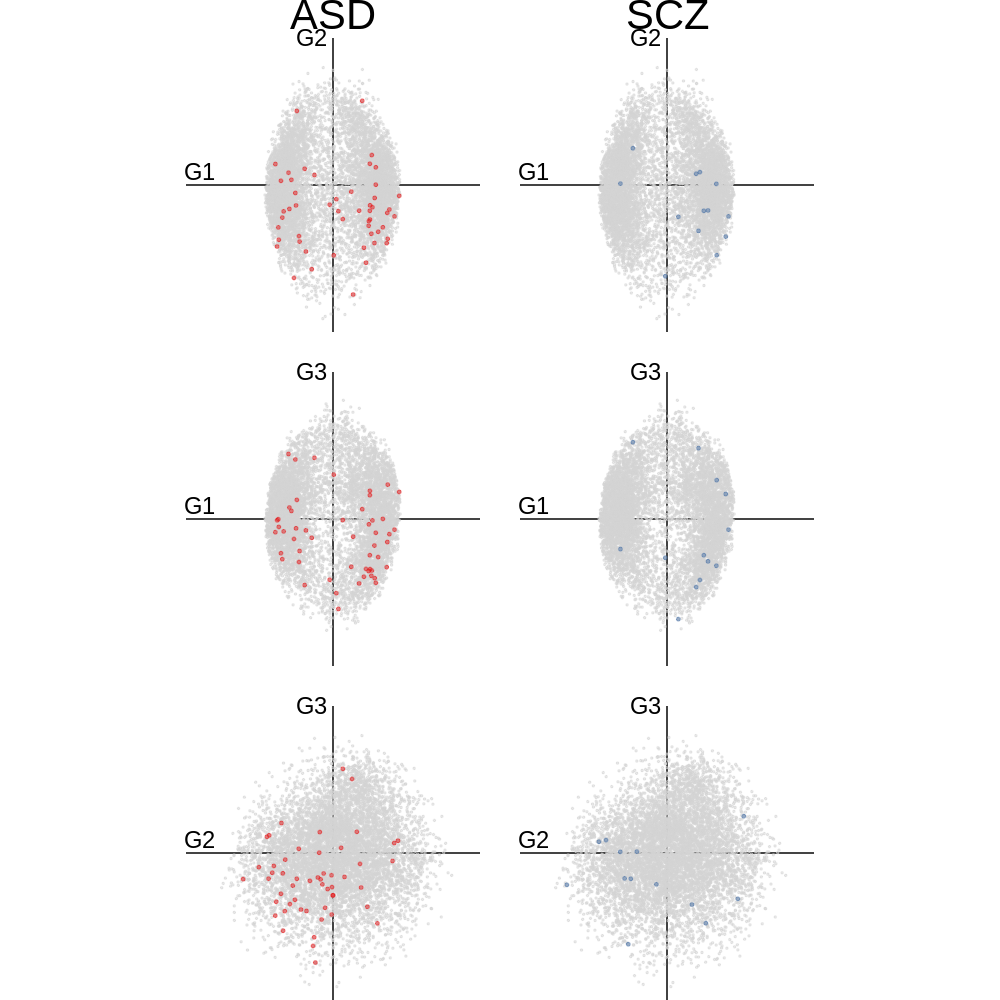

In [198]:
%%R -i weights_labels -w 10 -h 10 --units in -r 100
plot_weight_scatters_with_labels(weights_labels)

In [ ]:
%%R -i weights
library(gg3D)

corr <- corr %>% round(2) %>% rownames_to_column('d')
corr_zero <- corr %>% mutate(across(G1:G3, ~ 0))
axes_pos <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ 3.5))
axes_neg <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ -3.5))
axes <- rbind(axes_pos, axes_neg)
corr_plot <- rbind(corr, corr_zero, axes)
# corr_bg <- rbind(corr, corr %>% mutate(across(G2, ~ -10*.x)))

# theta <- 170
theta <- 0
phi <- 20

g1 <- ggplot(corr_plot, aes(x=G1, y=G2, z=G3, color=d)) +
axes_3D(theta=theta, phi=phi) + 
stat_3D(geom='line', theta=theta, phi=phi) +
# stat_3D(data=corr,
#     geom='point', size=3, theta=theta, phi=phi) +
stat_3D(data=rbind(corr, axes), geom='point', size=3, theta=theta, phi=phi) +
scale_color_manual(values=c('white', cols25(4))) +
axis_labs_3D(theta=theta, phi=phi, size=6,
       hjust=c(1,0.5, -0.5,-0.5, -0.5,0), 
       vjust=c(-0.5,-0.5, 1,0.5, 1.5,-1)) +
labs_3D(theta=theta, phi=phi, size=6,
       labs=c('G1','G2','G3'),
       hjust=c(-0.2,0,0.5), vjust=c(0.5,-1,-0.5)) +
theme_void() + 
theme(legend.position = "none")
g1